In [1]:
import sys
from pyprojroot import here as project_root

sys.path.insert(0, str(project_root()))

from bayes_opt.bo_utils import load_antibiotics_dataset, run_gp_ei_bo, min_so_far
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from fs_mol.utils.chem_utils import get_binary_fingerprints

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
task = load_antibiotics_dataset("antibiotics-dataset.xlsx", "../../fs_mol/preprocessing/utils/helper_files/")
dataset = task.samples

fp_all = get_binary_fingerprints(dataset, True)

x_all = torch.from_numpy(np.array(fp_all)).float().to(device)
y_all = torch.FloatTensor([float(x.numeric_label) for x in dataset]).to(device)

Skipping datapoint O=C([O-])C=CC(=O)[O-].[Fe+2], cannot featurise with current metadata.
Skipping datapoint CC(O)CN1CCN(CC(=O)[O-])CCN(CC(=O)[O-])CCN(CC(=O)[O-])CC1.[Gd+3], cannot featurise with current metadata.


In [3]:
num_init_points = 16
query_batch_size = 1
num_bo_iters = 20
kernel_type = "tanimoto"
init_from = 2000
noise_init = 0.01
noise_prior = True

num_repeats = 20

bo_records = []

In [4]:
for repeat in tqdm(range(num_repeats)):
    bo_record = run_gp_ei_bo(dataset, x_all, y_all, num_init_points, query_batch_size, num_bo_iters, kernel_type, device, init_from, noise_init, noise_prior)
    bo_records.append(min_so_far(bo_record))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:07<00:00, 63.38s/it]


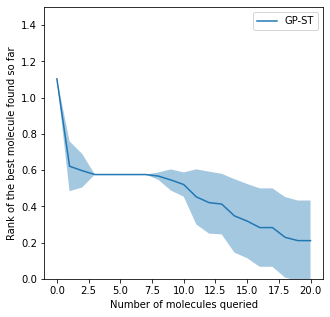

In [5]:
x_axis = np.arange(query_batch_size*num_bo_iters+1)

bo_records = np.array([[y_all[i].item() for i in bo_record] for bo_record in bo_records])
bo_records_mean = bo_records.mean(axis=0)
bo_records_std = bo_records.std(axis=0)

plt.figure(figsize=(5,5))

plt.plot(x_axis, bo_records_mean, label="GP-ST")
plt.fill_between(x_axis, bo_records_mean-bo_records_std, bo_records_mean+bo_records_std, alpha=0.4)

plt.xlabel("Number of molecules queried")
plt.ylabel("Top-1 relative growth")
plt.ylim(0, 1.5)
plt.legend()

In [6]:
import pickle

with open("outputs/gpst_bo_records.pkl", "wb") as output_file:
    pickle.dump(bo_records, output_file)